# photo-z estimation for edfs and cluster lensing
- Xiangchong Li, Prakruth Adari, Anja von der Linden
- LSST Science Piplines version: Weekly 2025_49


In [19]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.stats as stats

import fitsio
import xlens

import tables_io
import h5py
from astropy.table import Table
from astropy.stats import biweight_location, biweight_scale
from scipy.stats import sigmaclip
from matplotlib import cm

# =============================
# Matplotlib defaults
# =============================
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14
plt.rc("font", size=BIGGER_SIZE)
plt.rc("axes", titlesize=BIGGER_SIZE)
plt.rc("axes", labelsize=BIGGER_SIZE)
plt.rc("xtick", labelsize=BIGGER_SIZE)
plt.rc("ytick", labelsize=BIGGER_SIZE)
plt.rc("legend", fontsize=BIGGER_SIZE)
plt.rc("figure", titlesize=BIGGER_SIZE)

In [2]:
pscratch= "/gpfs02/astro/workarea/xli6/"
Dir = os.path.join(
    pscratch,
    "work/DP1/"
)
rail_pz_h5 = os.path.join(
    Dir, "photoz",
    "fzb_6bands/projects/com_cam/data/gold_rubin/output_estimate_fzboost.hdf5",
)

MODEL_PATH = os.path.join(
    Dir, "photoz",
    "fzb_6bands/projects/com_cam/data/gold_rubin/model_inform_fzboost.pkl",
)

data_fname = os.path.join(Dir, "rail_data", "data_edfs_with_mag.hdf5")
df = tables_io.read(
    data_fname,
    tType="astropyTable",
)
train_fname = os.path.join(Dir, "rail_data", "train_with_mag.hdf5")
df_train = tables_io.read(
    train_fname,
    tType="astropyTable",
)

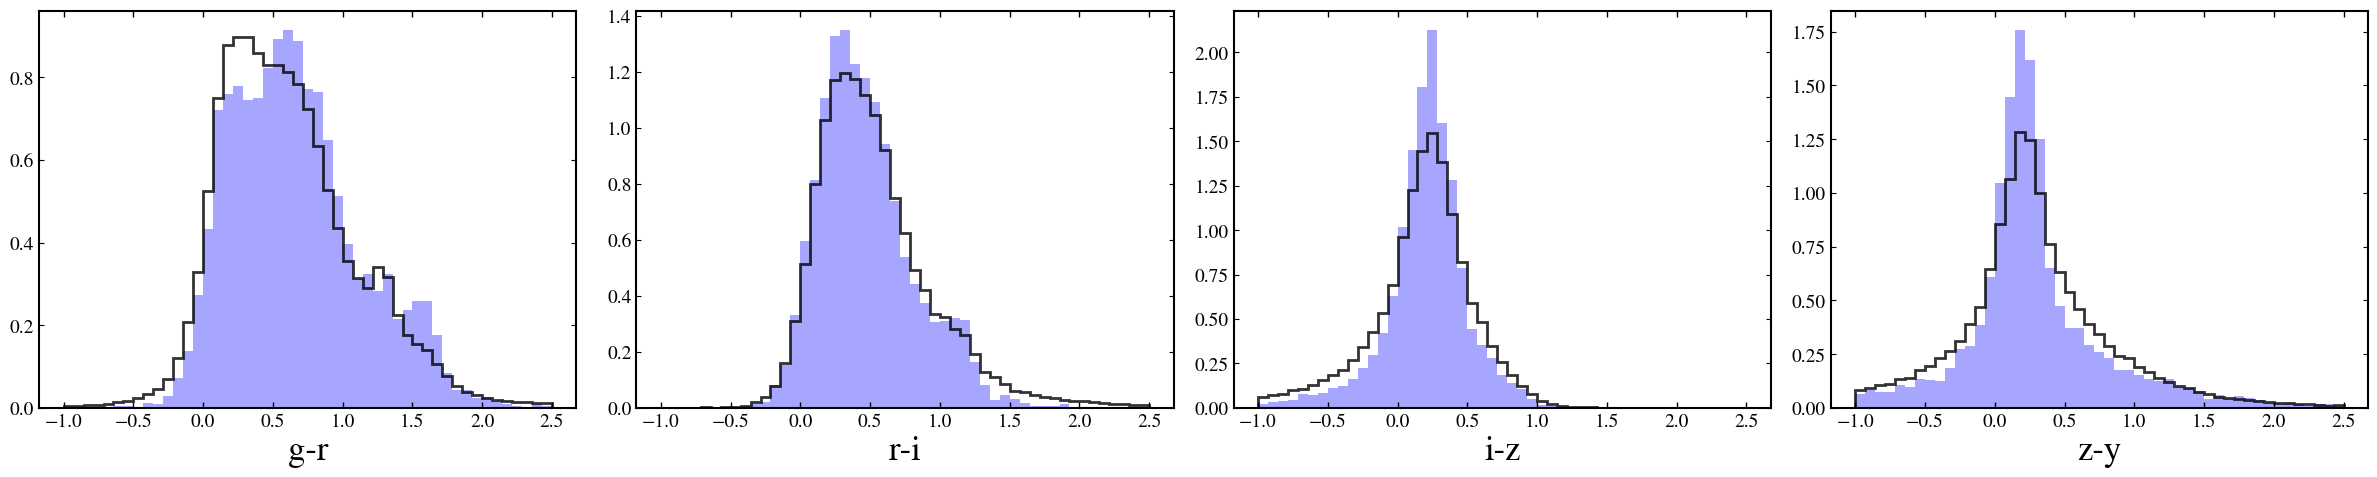

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))
xbins = np.linspace(0, 4, 14)
magbins = np.linspace(14, 26.0, 52)
colorbins = np.linspace(-1, 2.5, 50)
bands = "grizy"
for i in range(4):
    bandi = bands[i]
    bandj = bands[i + 1]
    xi = f"{bandi}_mag_gauss2"
    xj = f"{bandj}_mag_gauss2"
    axs[i].hist(df_train[xi] - df_train[xj], bins=colorbins, alpha=0.35, color="b", density=True)
    axs[i].hist(df[xi] - df[xj], bins=colorbins, alpha=0.8, color="k", density=True, histtype="step", linewidth=2.0)
    axs[i].set_xlabel(f"{bandi}-{bandj}", fontsize=25)
plt.tight_layout()

In [4]:
msk = (
    (df["u_mag_gauss2"] < 26.4) & 
    (df["g_mag_gauss2"] < 27.8) & 
    (df["r_mag_gauss2"] < 27.1) & 
    (df["i_mag_gauss2"] < 24.5) & 
    (df["z_mag_gauss2"] < 25.8) & 
    (df["y_mag_gauss2"] < 24.6) &
    ((df["i_fpfs1_m00"] + df["i_fpfs1_m20"]) / df["i_fpfs1_m00"] > 0.1) &
    ((df["i_fpfs1_m00"] + df["i_fpfs1_m20"]) / df["i_fpfs1_m00"] < 1.5)
)

(18.0, 25.0)

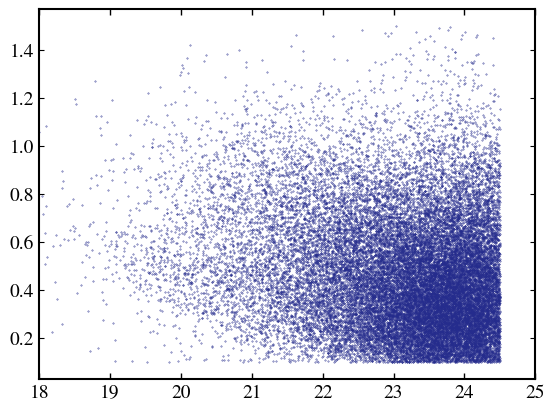

In [5]:
size = (df["i_fpfs1_m00"] + df["i_fpfs1_m20"]) / df["i_fpfs1_m00"]
# remove stars in the catalog with resolution cut
plt.scatter(df["i_mag_gauss2"][msk], size[msk], s=0.1)
plt.xlim(18, 25.0)

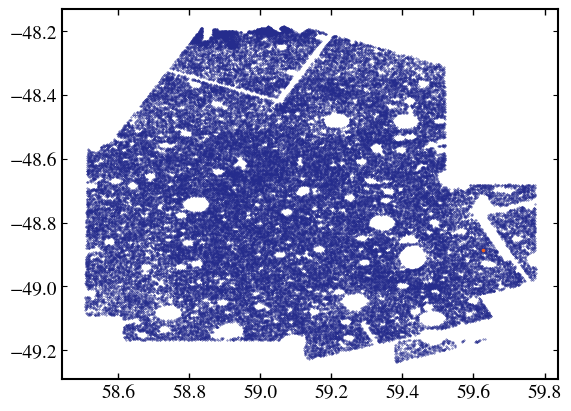

In [242]:
cluster_coords = (59.487317, -49.000349)
cluster_coords = (59.6271385, -48.88420908)

ra_bcg = cluster_coords[0]
dec_bcg = cluster_coords[1]
mm = (df["ra"] - 59.428) ** 2.0 + (df["dec"] + 48.908) ** 2.0 > 0.0015
plt.scatter(df["ra"][mm], df["dec"][mm], s=0.1)
plt.scatter(ra_bcg, dec_bcg, s=2.5)

In [243]:
cluster_coords

(59.6271385, -48.88420908)

In [244]:
zfname = os.path.join(Dir, "rail_data", "data_edfs_redshift.hdf5")
pzfname = os.path.join(Dir, "rail_data", "data_edfs_redshift_pdfs.fits")
if False:
    import pickle
    with open(MODEL_PATH, "rb") as f:
        pz_obj = pickle.load(f)
    fzbobj = xlens.catalog.redshift.flexzboostEstimator(pz_obj)
    redshift = fzbobj.get_z(
        df.as_array(),
        mag_zero=31.4,
        flux_name="gauss2",
        bands="ugrizy",
        ref_band="i",
        return_pdfs=True,
    )
    pdfs = redshift["pdfs"]
    fitsio.write(pzfname, pdfs)
    d2 = {k: v for k, v in redshift.items() if k != "pdfs"}
    tables_io.write(d2, zfname)
else:
    redshift = tables_io.read(
        zfname,
        tType="astropyTable",
    )
    pdfs = fitsio.read(pzfname)

np.float64(0.08282436482082149)

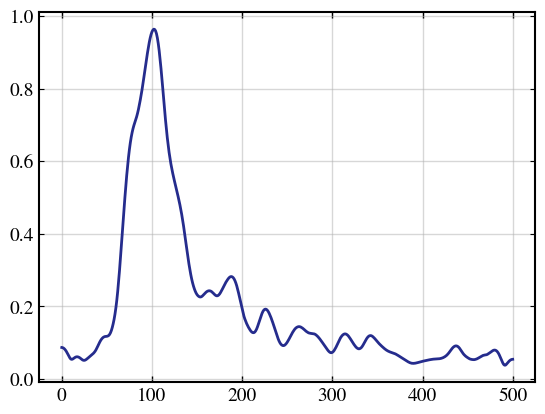

In [245]:
mm = np.sum(pdfs[:, 0:70], axis=1) * 0.01 < 0.25
plt.plot(np.average(pdfs[mm], axis=0))
plt.grid()
np.sum(np.average(pdfs[mm], axis=0)[0: 70]) * 0.01

In [246]:
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils
cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

z_cl = 0.7

# source properties
# assume sources redshift following a the DESC SRD distribution. This will need updating.

z_distrib_func = utils.redshift_distributions.desc_srd  

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

arcsec = 1 / 60**2
rng = np.random.default_rng()
omega_m = .31
omega_de= .69
omega_r = 0
H0 = 70 # km/s/Mpc
c = 3e5 # km/s

Hz = lambda z : c/(H0  * np.sqrt((omega_de + omega_m * (1+z)**3 + omega_r * (1+z)**4)))
chi_dl = lambda z, z0=0 : integrate.quad(Hz, z0, z)[0]
Da = lambda z : chi_dl(z)/(1+z)
beta_r = lambda zl, zs : integrate.quad(Hz, zl, zs)[0]/integrate.quad(Hz, 0, zs)[0]

def fast_bootstrap_mean(data, n_resamples=2000, ci_level=0.95):
    n = len(data)
    means = np.empty(n_resamples)
    for i in range(n_resamples):
        sample = np.random.choice(data, size=n, replace=True)
        means[i] = np.mean(sample)
    alpha = 1.0 - ci_level
    lower = np.percentile(means, 100 * alpha / 2)
    upper = np.percentile(means, 100 * (1 - alpha / 2))
    return np.array([lower, upper])
    
def anacal_get_tang_cross(cluster, sky_dist, bins, R, ci_level=.95):
    nb = len(bins) - 1
    res_avg = np.zeros(nb)
    res_err = np.zeros((nb, 2))
    
    tang_avg = np.zeros(nb)
    cross_avg = np.zeros_like(tang_avg)

    tang_err = np.zeros((nb, 2))
    cross_err = np.zeros_like(tang_err)

    bin_rs = []
    R_correction2 = np.mean(R) 
    
    for i in range(nb):
        # bin_rs.append(bins[i])
        ndx_filt = (sky_dist > bins[i]) * (sky_dist < bins[i+1])
        bin_rs.append(np.where(ndx_filt)[0])
        if np.sum(ndx_filt) < 1:
            continue
            
        sample = cluster[ndx_filt]
        sample_t = sample.real
        sample_x = sample.imag

        sr = R[ndx_filt] 
        print(np.sum(ndx_filt))
        R_correction = np.mean(sr)
        ta = np.mean(sample_t)/R_correction2
        xa = np.mean(sample_x)/R_correction2
        
        re = fast_bootstrap_mean(sr, ci_level=ci_level, n_resamples=500)
        te = fast_bootstrap_mean(sample_t, ci_level=ci_level, n_resamples=500)
        xe = fast_bootstrap_mean(sample_x, ci_level=ci_level, n_resamples=500)
        
        res_avg[i] = R_correction
        res_err[i] = re
        tang_avg[i] = ta
        cross_avg[i] = xa
        tang_err[i] = te / R_correction2
        cross_err[i] = xe / R_correction2
    return tang_avg, cross_avg, tang_err, cross_err, bin_rs, res_avg, res_err

In [259]:
msk = (
    (df["u_mag_gauss2"] < 27.5) & 
    (df["g_mag_gauss2"] < 27.5) & 
    (df["r_mag_gauss2"] < 24.5) &  # magnitude cut
    (df["i_mag_gauss2"] < 27.5) & 
    (df["z_mag_gauss2"] < 27.5) & 
    (df["y_mag_gauss2"] < 27.5) &
    ((df["i_fpfs1_m00"] + df["i_fpfs1_m20"]) / df["i_fpfs1_m00"] > 0.1) & # resolution cut
    (redshift["zmode"] > 0.80)   # redshift cut
    #mm
)
df2 = df[msk]

In [260]:
len(df2)

10559

In [261]:
c0 = 50.0
weights = {
    "g": 0.10110928,
    "r": 0.290752, 
    "i": 0.51740466 , 
    "z": 0.09073406,
}
m22c = np.zeros(len(df2))
dm22c_dg1 = np.zeros(len(df2))
m22s = np.zeros(len(df2))
dm22s_dg2 = np.zeros(len(df2))
m00 = np.zeros(len(df2))
dm00_dg1 = np.zeros(len(df2))
dm00_dg2 = np.zeros(len(df2))
for band in ["g", "r", "i", "z"]:
    w = weights[band]
    m22c = m22c + df2[f"{band}_fpfs1_m22c"] * w
    m22s = m22s + df2[f"{band}_fpfs1_m22s"] * w
    m00 = m00 + df2[f"{band}_fpfs1_m00"] * w
    dm22c_dg1 = dm22c_dg1 + df2[f"{band}_fpfs1_dm22c_dg1"] * w
    dm22s_dg2 = dm22s_dg2 + df2[f"{band}_fpfs1_dm22s_dg2"] * w
    dm00_dg1 = dm00_dg1 + df2[f"{band}_fpfs1_dm00_dg1"] * w
    dm00_dg2 = dm00_dg2 + df2[f"{band}_fpfs1_dm00_dg2"] * w
e1 = m22c / (m00 + c0) * df2["wsel"]
e2 = m22s / (m00 + c0) * df2["wsel"]
de1_dg1 = dm22c_dg1 / (m00 + c0) - m22c / (m00 + c0)**2.0 * dm00_dg1
de2_dg2 = dm22s_dg2 / (m00 + c0) - m22s / (m00 + c0)**2.0 * dm00_dg2
res = (
    de1_dg1 * df2["wsel"] + df2["dwsel_dg1"]* m22c / (m00 + c0) +
    de2_dg2 * df2["wsel"] + df2["dwsel_dg2"]* m22s / (m00 + c0)
) / 2.0

In [262]:
source_phi = np.arctan2(df2['dec'] - cluster_coords[1], (cluster_coords[0] - df2['ra'])*np.cos(np.deg2rad(cluster_coords[1])))
ang_dist = np.sqrt(((df2['ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1])))**2 + (df2['dec'] - cluster_coords[1])**2)
sky_distance = Da(z_cl) * ang_dist * (np.pi/180)

trial_shear = e1 + 1.j*e2
cl_shear = trial_shear * -1*np.exp(-2j*source_phi)

bins_mpc = clmm.make_bins(0.2,9,nbins=7, method='evenlog10width')
bin_mids = 1/2 * (bins_mpc[1:] + bins_mpc[:-1])
shear_cl = anacal_get_tang_cross(cl_shear, sky_distance, bins_mpc, res, ci_level=.68)

moo = clmm.Modeling(massdef="critical", delta_mdef=500, halo_profile_model="nfw")
moo.set_cosmo(cosmo)
moo.set_concentration(5)
moo.set_mass(4e14)

rproj = np.logspace(np.log10(0.2),np.log10(9.), 100)
gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

4
24
57
126
363
807
1657


In [268]:
bin_mids / Da(z_cl) / (np.pi/180)

array([0.01062411, 0.01830063, 0.03152384, 0.05430157, 0.09353747,
       0.16112348, 0.27754413])

In [267]:
Da.

<function __main__.<lambda>(z)>

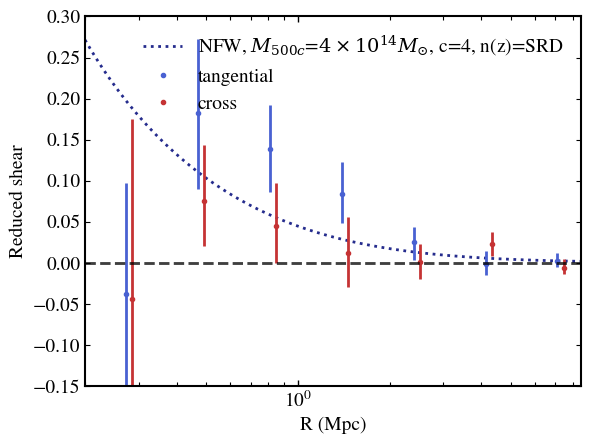

In [263]:
plt.close()
cmap = cm.coolwarm

plt.plot(rproj, gt_z, label=r'NFW, $M_{500c}$=$4 \times 10^{14} M_{\odot}$, c=4, n(z)=SRD', ls=':')
plt.plot(bin_mids, shear_cl[0], '.', label='tangential', color=cmap(.05))
plt.vlines(bin_mids, shear_cl[2][:,0], shear_cl[2][:,1], color=cmap(0.05))

plt.plot(1.05*bin_mids, shear_cl[1], '.', label='cross', color=cmap(.95))
plt.vlines(1.05*bin_mids, shear_cl[3][:,0], shear_cl[3][:,1], color=cmap(0.95))
plt.axhline(0, ls='--', color='k', alpha=.5)

chi2_t = np.sum(shear_cl[0] ** 2.0 / ((shear_cl[2][:,0] - shear_cl[2][:,1]) / 2.0) ** 2.0)
chi2_x = np.sum(shear_cl[1] ** 2.0 / ((shear_cl[3][:,0] - shear_cl[3][:,1]) / 2.0) ** 2.0)

plt.semilogx()
plt.axhline(0, ls='--', color='k', alpha=.5)
plt.xlim([0.2,8.5])
plt.ylim([-0.15,0.30])
plt.ylabel("Reduced shear")
plt.xlabel("R (Mpc)")
plt.legend(frameon=False, loc='upper right')

In [264]:
np.sqrt(chi2_t)

np.float64(4.187381597511938)

In [16]:
np.sqrt(chi2_x)

np.float64(2.0261149479220473)

In [17]:
import scipy
scipy.stats.chi2.sf(chi2_t, 7)

np.float64(0.00389831520021454)

In [18]:
scipy.stats.chi2.sf(chi2_x, 7)

np.float64(0.7675906448615276)

In [20]:
def schirmer_filter(radius,aperture_size=8000,x_cut=0.15,a=6,b=150,c=47,d=50,*_):
    '''
    The Schirmer Filter, a filter which is optimized for detecting NFW-like structures in shear-fields.
    
    Args:
        radius: Numpy array; an array of radii to evaluate the filter on
        aperture_size: float-like; the 'schirmer-radius' of the filter
        x_cut: float-like; specifies the filter-sloap and sets the characteristic-scale of the filter to x_cut*smoothing
    
    Returns:
        Q; Numpy array; an array containing the filter evaluated at each radius
    
    '''
    
    x = radius/aperture_size
    Q = ( 1/( 1 + np.exp(a - b*x) + np.exp(-c + d*x)) )*( np.tanh(x/x_cut)/(x/x_cut) )
    return Q
    
def compute_mass_map(x_grid,y_grid,x,y,g1,g2,weights,q_filter,filter_kwargs={}):
    '''
    This function computes the mass aperture-statistics at each point on a specified grid. Run quality-cuts, NaN filtering, etc. before this step!
    
    Args:
        x: Numpy array; an array of x-coordinates for each object
        y: Numpy array; an array of y-coordinates for each object
        x_grid: Numpy array; an NxM array of x-coordinates to sample the aperture-mass on
        y_grid: Numpy array; an NxM array of y-coordinates to sample the aperture-mass on
        g1; Numpy array; the shear g1 for each object
        g2; Numpy array; the shear g2 for each object
        weights: Numpy array; the weight for each object's shear
        q_filter; function; the filter-function used to compute Map
        kwargs; dict; kwargs passed to w_filter
    
    Returns:
        Map_E: Numpy array; an NxM array containing the E-mode aperture mass evaluated at each grid-point
        Map_B: Numpy array; an NxM array containing the B-mode aperture mass evaluated at each grid-point
        Map_V: Numpy array; an NxM array containing the variance in the aperture mass evaluated at each grid-point

    '''

    ny, nx = y_grid.shape
    
    Map_E = np.zeros((ny, nx))
    Map_B = np.zeros((ny, nx))
    Map_V = np.zeros((ny, nx))
    
    if 'aperture_size' not in filter_kwargs:
        filter_area = np.pi * (0.55)**2
    else:
        filter_area = np.pi * filter_kwargs['aperture_size']**2
    
    comp_shear = g1 + 1j*g2
    g_mag = np.mean(g1**2 + g2**2) * np.ones_like(g1)
    
    for i in range(ny):
        for j in range(nx):
            delta_x =  x - x_grid[i, j]
            delta_y =  y - y_grid[i, j]
            radius = np.sqrt(delta_x**2 + delta_y**2)
            theta = np.arctan2(delta_y,delta_x)
            rotated_shear = comp_shear * -1*np.exp(-2j*theta)
            g_T = rotated_shear.real
            g_X = rotated_shear.imag
            filter_values = q_filter(radius, a=7, b=150, **filter_kwargs)
            weight_sum = np.sum(weights)
            Map_E[i,j] = np.sum(filter_values*g_T*weights)*filter_area/weight_sum
            Map_B[i,j] = np.sum(filter_values*g_X*weights)*filter_area/weight_sum
            Map_V[i,j] = np.sum( (filter_values**2)*g_mag*(weights**2) )*(filter_area**2)/(2*(weight_sum**2))
    return Map_E, Map_B, Map_V

In [221]:
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord
from astropy.coordinates import SkyCoord
import astropy.units as u

cluster_coords = (59.487317, -49.000349)
ra_bcg = cluster_coords[0]
dec_bcg = cluster_coords[1]

# build wcs centered on BCG
flat_wcs = WCS(naxis=2)
crval_sky = [ra_bcg*u.deg,dec_bcg*u.deg]
flat_wcs.wcs.crval = [ra_bcg,dec_bcg]
flat_wcs.wcs.crpix = [0,0] # assign 0,0 to the center, shouldn't matter
flat_wcs.wcs.cdelt = [-0.2/3600,0.2/3600] # match angular resolution of LSST, 0.2"
flat_wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
flat_wcs.wcs.radesys = 'ICRS'
flat_wcs.wcs.equinox = 2000
flat_wcs.wcs.cd = [[-0.2/3600,0],[0,0.2/3600]]

# compute coords in the flat-sky
# coords = SkyCoord(ra=merged_cat_wl['coord_ra'][source_filt][to_use],dec=merged_cat_wl['coord_dec'][source_filt][to_use],unit='degree')
coords = SkyCoord(ra=df2['ra'],dec=df2['dec'],unit='degree')
bcg = SkyCoord(ra_bcg*u.deg, dec_bcg*u.deg)
x0, y0 = skycoord_to_pixel(bcg, flat_wcs, origin=0)

x, y = skycoord_to_pixel(coords, flat_wcs, origin=0)

scale = 0.2/3600  # deg per pixel
x = (x - x0) * scale
y = (y - y0) * scale

# for now I'll weight everything uniformly
weights = np.ones(len(x))

# Define an NxN grid centered on the cluster
# Spans 1-deg centered at the BCG
# scale so that its in pixel coordinates for computing
N = 161
rr = 0.16

mid_x = 0
mid_y = 0

x_grid_samples = np.linspace(mid_x-rr,mid_x+rr,N)
y_grid_samples = np.linspace(mid_y-rr,mid_y+rr,N)
x_grid, y_grid = np.meshgrid(x_grid_samples, y_grid_samples, indexing="xy")
ny, nx = y_grid.shape

In [223]:
global_R = np.mean(res)
print(global_R)
weights = np.ones(len(x))
g1 = e1 / global_R
g2 = e2 / global_R

0.2521953947222718


In [224]:
e_ap,b_ap,v_ap = compute_mass_map(
    x_grid,y_grid,
    x,y,
    g1,g2,
    weights,
    schirmer_filter,
    filter_kwargs={'aperture_size':0.15}
)

0.39382234668962074


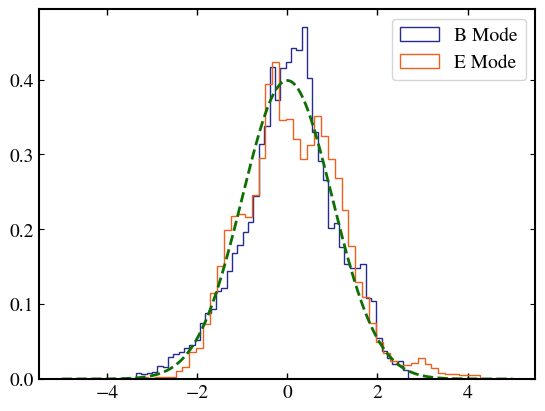

In [225]:
sky_box = np.array([[x_grid.max(), x_grid.min()],[y_grid.min(), y_grid.max()]])
test_xs = np.linspace(-5, 5, num=1001)
standard = stats.norm(0, 1)
normal_dist = standard.pdf(test_xs)
plt.hist((b_ap/np.sqrt(np.mean(v_ap))).flatten(), bins=51, label='B Mode', histtype='step', density=True)
plt.hist((e_ap/np.sqrt(np.mean(v_ap))).flatten(), bins=51, label='E Mode', histtype='step', density=True)
plt.plot(test_xs, normal_dist, '--')
plt.legend();

[4.27241019]


Text(0.05, 0.5, 'DEC')

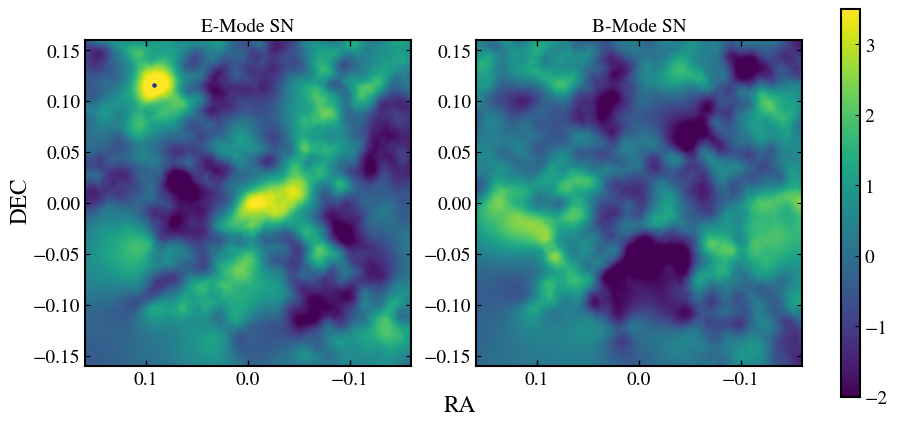

In [226]:
fig, axs = plt.subplots(ncols=2,figsize=(10,6))

ax = axs[0]
ax.set_title('E-Mode SN')
extent=(rr, -rr, -rr, rr)
MapE = ax.imshow(
    e_ap /np.sqrt(np.mean(v_ap)),
    vmin=-2, vmax=3.5,
    origin='lower', 
    extent=extent,
)
y_p, x_p =np.where(e_ap /np.sqrt(np.mean(v_ap)) == np.max(e_ap /np.sqrt(np.mean(v_ap))))
print((e_ap /np.sqrt(np.mean(v_ap)))[y_p, x_p])
x_vals = np.linspace(extent[0], extent[1], N)
y_vals = np.linspace(extent[2], extent[3], N)
ax.scatter(x_vals[x_p], y_vals[y_p], s=5.0)

ax = axs[1]
ax.set_title('B-Mode SN')
MapB = ax.imshow(
    b_ap/np.sqrt(np.mean(v_ap)),
    vmin=-2, vmax=3.5,
    origin='lower', 
    extent=extent
)

# for xx in axs:
#     xx.plot(ra_bcg, dec_bcg, 'rx')
cbar = fig.colorbar(MapE, ax=axs,fraction=0.025)

fig.supxlabel("RA", y=0.14)
fig.supylabel("DEC", x=0.05)

In [227]:
y_grid[y_p, x_p]

array([0.116])

In [228]:
x_grid[y_p, x_p]

array([-0.092])

In [241]:
pixel_to_skycoord(x_grid[y_p, x_p] / scale, y_grid[y_p, x_p] / scale, wcs=flat_wcs)

<SkyCoord (ICRS): (ra, dec) in deg
    [(59.6271385, -48.88420908)]>

In [ ]:
cluster_coords = (59.487317, -49.000349)

In [219]:
x_p / scale

array([612000.])

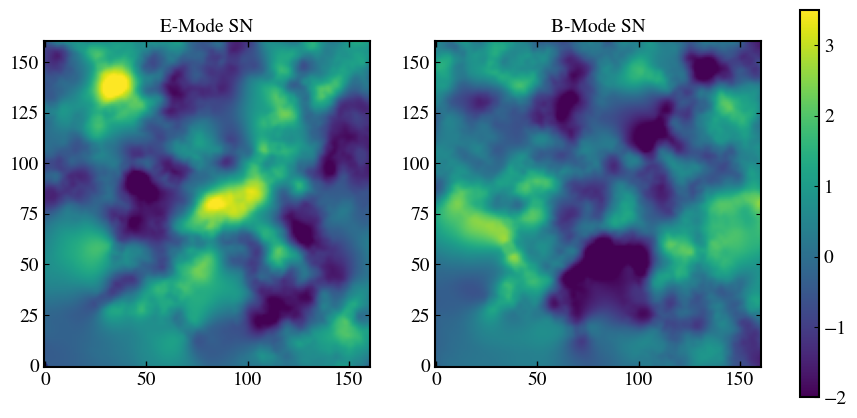

In [205]:
fig, axs = plt.subplots(ncols=2,figsize=(10,6))

ax = axs[0]
ax.set_title('E-Mode SN')
MapE = ax.imshow(
    e_ap /np.sqrt(np.mean(v_ap)),
    vmin=-2, vmax=3.5,
    origin='lower', 
)
y , x =np.where(e_ap /np.sqrt(np.mean(v_ap)) == np.max(e_ap /np.sqrt(np.mean(v_ap))))
x_coord = x_vals[x]
y_coord = y_vals[y]
ax.scatter(x_coord, y_coord, s=5.0)

ax = axs[1]
ax.set_title('B-Mode SN')
MapB = ax.imshow(
    b_ap/np.sqrt(np.mean(v_ap)),
    vmin=-2, vmax=3.5,
    origin='lower', 
)

# for xx in axs:
#     xx.plot(ra_bcg, dec_bcg, 'rx')
cbar = fig.colorbar(MapE, ax=axs,fraction=0.025)

In [178]:
x_coord

array([0.092])

In [179]:
y_coord

array([0.116])

In [180]:
y, x

(array([138]), array([34]))

In [181]:
print(cluster_coords[0] + x_grid[y, x])
print(cluster_coords[1] + y_grid[y, x])

[59.395317]
[-48.884349]
